<a href="https://colab.research.google.com/github/EricEricEricJin/ECE539-Group-Project/blob/master/slicer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras

import os

Mounted at /content/drive


In [5]:
CHUNK_SAMPLE = 661500 // 5
DIR_NAME = "/content/drive/My Drive/Colab Notebooks/ECE539_Project/"
model = keras.models.load_model(DIR_NAME + f"ms_clf_weights_N={CHUNK_SAMPLE}")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 512, 64, 1)        0         
                                                                 
 normalization (Normalizati  (None, 512, 64, 1)        3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 510, 62, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 508, 60, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 30, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 254, 30, 64)       0

In [6]:
def predict_stream(BV, STEP_SIZE):
  # Load audio file and parse marker file
  wav_filepath = DIR_NAME + f"xxm_mixed/{BV}.wav"
  audio_binary = tf.io.read_file(wav_filepath)
  marker = np.loadtxt(
    DIR_NAME + f"xxm_mixed/{BV}.csv",
    delimiter=',')
  marker = marker[:,0] * 3600 + marker[:,1] * 60 + marker[:,2]

  # Decode audio and transform to spectrograms
  audio, _ = tf.audio.decode_wav(audio_binary)
  waveform = tf.squeeze(audio)

  def get_spectrogram(waveform):
      spectrogram = tf.signal.stft(
          waveform, frame_length=255, frame_step=128)
      # removes the phase (we only care about the magnitude)
      spectrogram = tf.abs(spectrogram)
      return spectrogram

  pred_list = []
  model_input_list = []

  for i in range((len(waveform) - CHUNK_SAMPLE) // STEP_SIZE + 1):
    wave_ith = waveform[i * STEP_SIZE : i * STEP_SIZE + CHUNK_SAMPLE]
    model_input_list.append(tf.expand_dims(get_spectrogram(wave_ith), -1))

  # Use model to predict
  input_shape = model_input_list[0].shape
  pred_list = model.predict(tf.reshape(model_input_list, (len(model_input_list), *input_shape)))
  return marker, pred_list

81/81 [==============================] - 2s 24ms/step


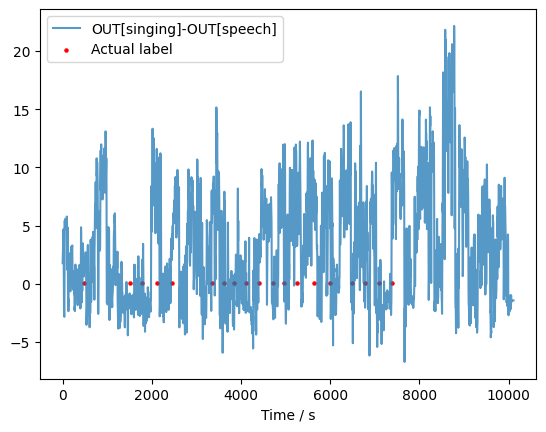

In [80]:
STEP_SIZE = CHUNK_SAMPLE//2
marker, pred_list = predict_stream("BV15z4y1M7ee", STEP_SIZE)

plt.xlabel("Time / s")
plt.plot(np.linspace(0, 10111, len(pred_list)), pred_list[:,1] - pred_list[:,0], alpha=0.75, label="OUT[singing]-OUT[speech]")
plt.scatter(marker, np.zeros(len(marker)) + 0.1, c='r', s=5, label="Actual label")
plt.legend()
plt.show()

In [81]:
pred_1D = pred_list[:,1] - pred_list[:,0]

In [82]:
#############
# Apply MLP #
#############
MLP_INPUT_SIZE = 50
series_mlp_model = keras.models.load_model(DIR_NAME + "pred_series_mlp_weights")
series_mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 60)                3060      
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 8762 (34.23 KB)
Trainable params: 8762 (34.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
MLP_STEP =  MLP_INPUT_SIZE // 5
mlp_input = np.array([pred_1D[i:i+MLP_INPUT_SIZE] for i in range(0, len(pred_list) - MLP_INPUT_SIZE + 1, MLP_STEP)])
mlp_pred = series_mlp_model.predict(mlp_input)
mlp_pred.shape
mlp_pred_1D = mlp_pred[:,1]-mlp_pred[:,0]


8/8 [==============================] - 0s 2ms/step


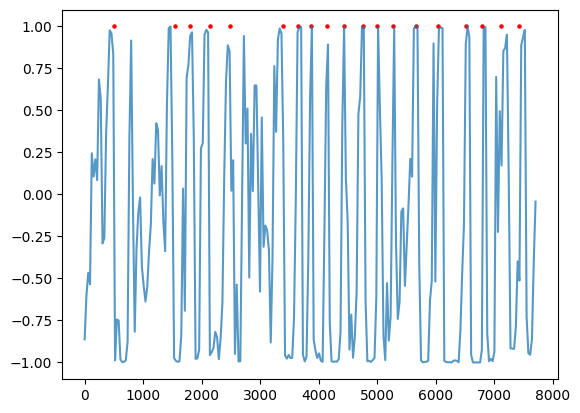

In [147]:
TIME_SEC = ((len(mlp_pred)-1) * MLP_STEP + MLP_INPUT_SIZE) * STEP_SIZE // SAMPLE_RATE
# plt.xlim([4900, 5100])
plt.plot(np.linspace(0, TIME_SEC, len(mlp_pred)), mlp_pred_1D, alpha=0.75, label="pred")
plt.scatter(marker+30, np.ones(len(marker)), c='r', s=5, label="Actual label")

In [ ]:
# Deprecated, use MLP instead.
#########################
# Apply majority voting #
#########################

# MV_PTS = 26
# SAMPLE_RATE = 22050

# mv_list = []
# for i in range(0, len(pred_list) - MV_PTS + 1, MV_PTS):
#   if (pred_list[i : i+MV_PTS, 1] - pred_list[i : i+MV_PTS, 0] > 0).sum() > MV_PTS / 2:
#     mv_list.append(1)
#   else:
#     mv_list.append(0)
# mv_list = np.array(mv_list)


# plt.xlim([4000, 6000])

# plt.plot(np.linspace(0, 10111, len(mv_list)), mv_list, alpha=0.75, label="pred")
# plt.scatter(marker + MV_PTS/2 * STEP_SIZE / SAMPLE_RATE, np.ones(len(marker)), c='r', s=5, label="Actual label")

# plt.show()

### Evaluation

In [86]:
marker


array([ 480., 1518., 1780., 2120., 2447., 3360., 3614., 3840., 4109.,
       4401., 4726., 4968., 5250., 5628., 6004., 6493., 6771., 7092.,
       7392.])

In [146]:
# def eval_pred(marker, pred, step_sec):
true_positive = 0
step_sec = 75
for m in marker:
  if mlp_pred_1D[int((m+30)/step_sec)] > 0 or mlp_pred_1D[int((m+30)/step_sec)+1] > 0:
    true_positive += 1
print(true_positive, "/", len(marker))
# Actually from above figure the outcome should be much better than 11/19.
# Refine the evaluation method.

11 / 19
